In [3]:
!pip install neo4j pandas seaborn

You should consider upgrading via the '/Users/gu/Workspace/jupyter-notebooks/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot
import pandas as pd
from neo4j import GraphDatabase

driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'fammepassa'))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [6]:
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (a:Article) ASSERT a.url IS UNIQUE;")

""


In [7]:
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (e:Entity) ASSERT e.wikiDataItemId is UNIQUE;")
run_query("CREATE CONSTRAINT IF NOT EXISTS ON (t:Tag) ASSERT t.name is UNIQUE;")

""


In [8]:
run_query("""
CALL apoc.load.html("https://www.cnet.com/news/", 
  {topics:"div.tag-listing > ul > li > a"}) YIELD value
UNWIND value.topics as topic  
WITH "https://www.cnet.com" + topic.attributes.href as link
CALL apoc.load.html(link, {article:"div.row.asset > div > a"}) YIELD value as articles
UNWIND articles.article as article
WITH distinct "https://www.cnet.com" + article.attributes.href as article_link
MERGE (a:Article{url:article_link});
""")

""


In [9]:
run_query("""
MATCH (a:Article)
CALL apoc.load.html(a.url,
{date:"time", title:"h1.speakableText", text:"div.article-main-body > p", tags: "div.tagList > a"}) YIELD value
SET a.datetime = datetime(value.date[0].attributes.datetime)
FOREACH (_ IN CASE WHEN value.title[0].text IS NOT NULL THEN [true] ELSE [] END | 
           CREATE (a)-[:HAS_TITLE]->(:Section{text:value.title[0].text})
)
FOREACH (t in value.tags | 
MERGE (tag:Tag{name:t.text}) MERGE (a)-[:HAS_TAG]->(tag)
)
WITH a, value.text as texts
UNWIND texts as text
WITH a,text
WHERE text.text IS NOT NULL
CREATE (a)-[:HAS_SECTION]->(:Section{text:text.text});
""")

""


In [10]:
run_query("""
MATCH (n:Tag)
WHERE n.name CONTAINS "Notification"
DETACH DELETE n;
""")

""


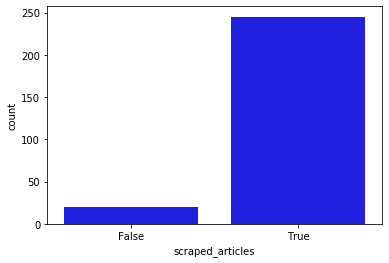

In [11]:
data = run_query("""
MATCH (a:Article)
RETURN exists((a)-[:HAS_SECTION]->()) as scraped_articles, count(*) as count
""")
ax = sns.barplot(x="scraped_articles", y="count", data=data, color="blue")

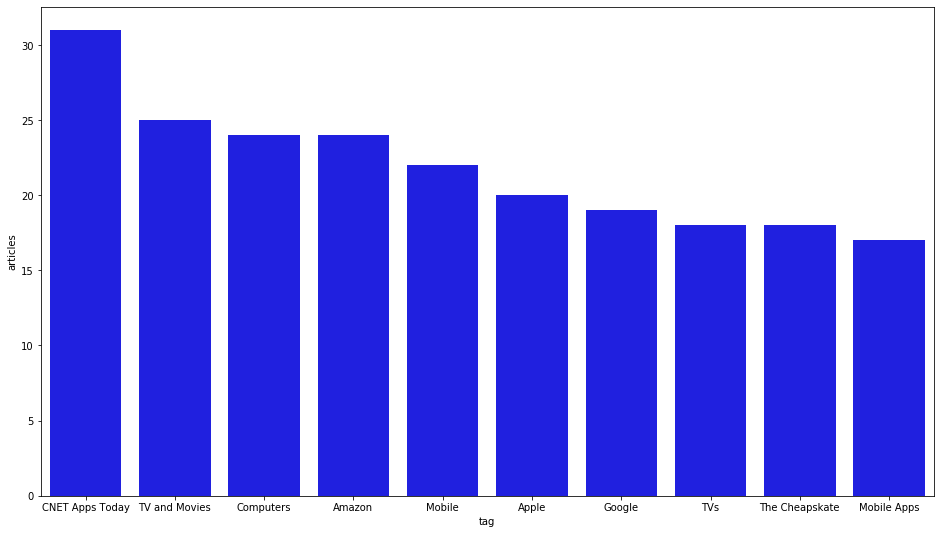

In [12]:
data = run_query("""
MATCH (n:Tag)
RETURN n.name as tag, size((n)<-[:HAS_TAG]-()) as articles
ORDER BY articles DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="tag", y="articles", data=data, color="blue")

In [2]:
user_key = "msipqwjijodviwghewtfbybshzezmj"

In [7]:
run_query("""
CALL apoc.periodic.iterate('
 MATCH (s:Section) RETURN s
 ','
 WITH s, "http://www.wikifier.org/annotate-article?" +
        "text=" + apoc.text.urlencode(s.text) + "&" +
        "lang=en&" +
        "pageRankSqThreshold=0.80&" +
        "applyPageRankSqThreshold=true&" +
        "nTopDfValuesToIgnore=200&" +
        "nWordsToIgnoreFromList=200&" +
        "minLinkFrequency=100&" + 
        "maxMentionEntropy=10&" +
        "wikiDataClasses=false&" +
        "wikiDataClassIds=false&" +
        "userKey=" + $userKey as url
CALL apoc.log.info(toString(ID(s)))
CALL apoc.load.json(url) YIELD value
UNWIND value.annotations as annotation
MERGE (e:Entity{wikiDataItemId:annotation.wikiDataItemId})
ON CREATE SET e.title = annotation.title, e.url = annotation.url
MERGE (s)-[:HAS_ENTITY]->(e)',
{batchSize:100, params: {userKey:$user_key}})
""", {"user_key":user_key})

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams
0,37,3627,3795,3327,300,3,0,{'Can't read url or key http://www.wikifier.or...,"{'total': 37, 'committed': 34, 'failed': 3, 'e...","{'total': 3627, 'committed': 3327, 'failed': 3...",False,{}


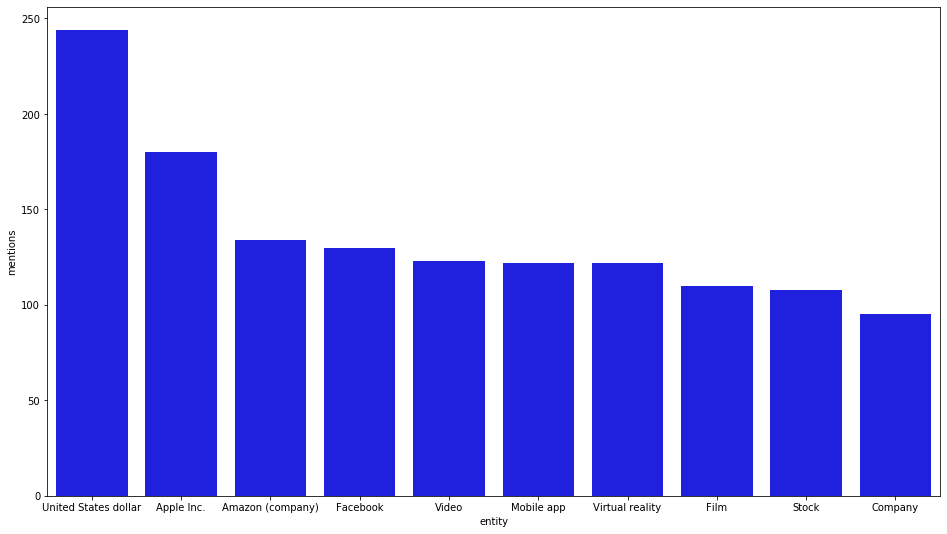

In [8]:
data = run_query("""
MATCH (e:Entity)
RETURN e.title as entity, size((e)<--()) as mentions
ORDER BY mentions DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")


In [9]:
run_query("""
MATCH (e:Entity)<-[:HAS_ENTITY]-()<-[:HAS_SECTION]-()-[:HAS_TAG]->(tag)
WITH tag.name as tag, e.title as title, count(*) as mentions
ORDER BY mentions DESC
RETURN tag, collect(title)[..3] as top_3_mentions
LIMIT 5;
""")

,tag,top_3_mentions
0,GameStop,"[Stock, GameStop, United States dollar]"
1,Investing,"[Stock, GameStop, United States dollar]"
2,Robinhood,"[Stock, GameStop, Trade]"
3,Stock Market,"[Stock, GameStop, United States dollar]"
4,Virtual Reality,"[Virtual reality, Facebook, Technology]"


In [10]:
run_query("""
// Iterate over entities
MATCH (e:Entity)
// Prepare a SparQL query
WITH 'SELECT *
      WHERE{
        ?item rdfs:label ?name .
        filter (?item = wd:' + e.wikiDataItemId + ')
        filter (lang(?name) = "en" ) .
      OPTIONAL{
        ?item wdt:P31 [rdfs:label ?class] .
        filter (lang(?class)="en")
      }}' AS sparql, e
// make a request to Wikidata
CALL apoc.load.jsonParams(
    "https://query.wikidata.org/sparql?query=" + 
    apoc.text.urlencode(sparql),
     { Accept: "application/sparql-results+json"}, null)
YIELD value
UNWIND value['results']['bindings'] as row
FOREACH(ignoreme in case when row['class'] is not null then [1] else [] end | 
        MERGE (c:Class{name:row['class']['value']})
        MERGE (e)-[:INSTANCE_OF]->(c));    
""")

""


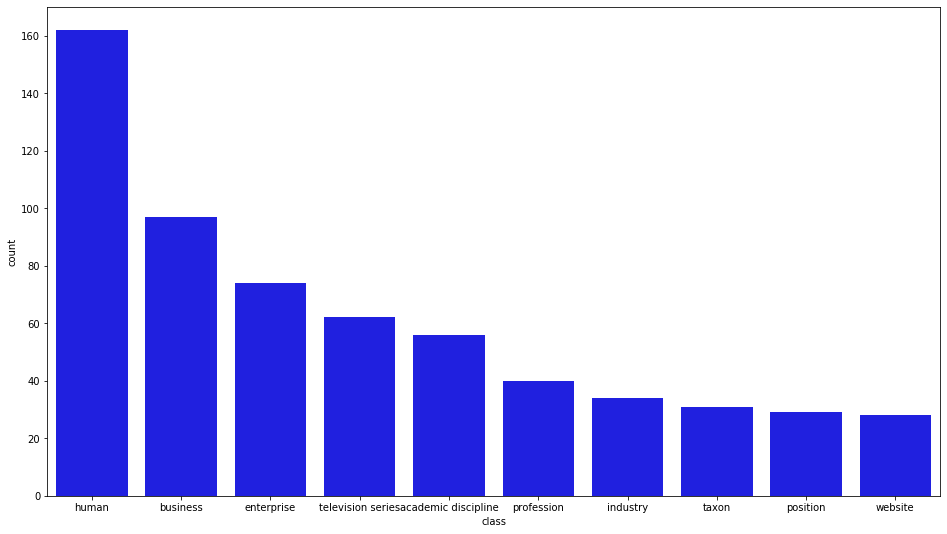

In [11]:
data = run_query("""
MATCH (c:Class)
RETURN c.name as class, size((c)<--()) as count
ORDER BY count DESC LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="class", y="count", data=data, color="blue")


In [12]:
run_query("""
MATCH (e:Entity)-[:INSTANCE_OF]->(c:Class)
WHERE c.name in ["human"]
SET e:Person;
""")
run_query("""
MATCH (e:Entity)-[:INSTANCE_OF]->(c:Class)
WHERE c.name in ["business", "enterprise"]
SET e:Business;
""")

""


[Text(0, 0, 'Apple Inc.'),
 Text(0, 0, 'Amazon (company)'),
 Text(0, 0, 'GameStop'),
 Text(0, 0, 'Google'),
 Text(0, 0, 'The Walt Disney Company'),
 Text(0, 0, 'Sony'),
 Text(0, 0, 'Netflix'),
 Text(0, 0, 'Microsoft'),
 Text(0, 0, 'Marvel Comics'),
 Text(0, 0, 'Best Buy')]

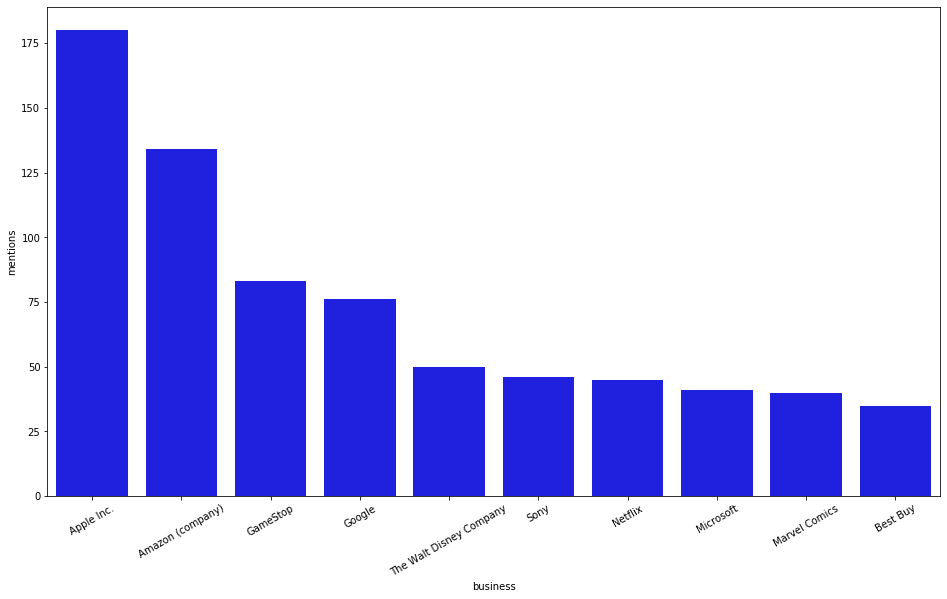

In [13]:
data = run_query("""
MATCH (b:Business)
RETURN b.title as business, size((b)<-[:HAS_ENTITY]-()) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="business", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


In [14]:
run_query("""
MATCH (e:Business)
// Prepare a SparQL query
WITH 'SELECT *
      WHERE{
        ?item rdfs:label ?name .
        filter (?item = wd:' + e.wikiDataItemId + ')
        filter (lang(?name) = "en" ) .
      OPTIONAL{
        ?item wdt:P452 [rdfs:label ?industry] .
        filter (lang(?industry)="en")
      }}' AS sparql, e
// make a request to Wikidata
CALL apoc.load.jsonParams(
    "https://query.wikidata.org/sparql?query=" + 
    apoc.text.urlencode(sparql),
     { Accept: "application/sparql-results+json"}, null)
YIELD value
UNWIND value['results']['bindings'] as row
FOREACH(ignoreme in case when row['industry'] is not null then [1] else [] end | 
        MERGE (i:Industry{name:row['industry']['value']})
        MERGE (e)-[:PART_OF_INDUSTRY]->(i));
""")

""


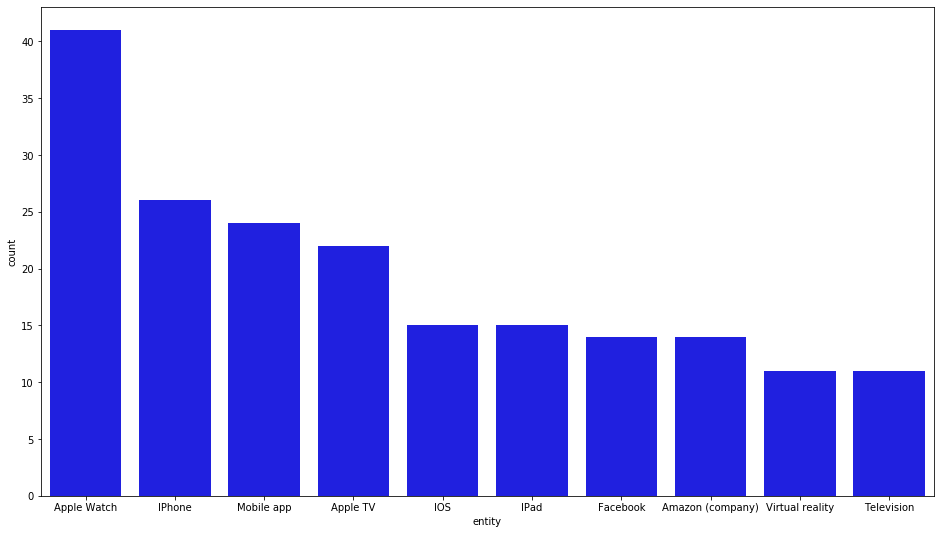

In [15]:
data = run_query("""
MATCH (b:Business)
WITH b, size((b)<-[:HAS_ENTITY]-()) as mentions
ORDER BY mentions DESC 
LIMIT 1
MATCH (other_entities)<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(b)
RETURN other_entities.title as entity, count(*) as count
ORDER BY count DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="count", data=data, color="blue")


In [16]:
data

,entity,count
0,Apple Watch,41
1,IPhone,26
2,Mobile app,24
3,Apple TV,22
4,IOS,15
5,IPad,15
6,Facebook,14
7,Amazon (company),14
8,Virtual reality,11
9,Television,11


[Text(0, 0, 'retail'),
 Text(0, 0, 'e-commerce'),
 Text(0, 0, 'web service'),
 Text(0, 0, 'web hosting service'),
 Text(0, 0, 'communication device'),
 Text(0, 0, 'telecommunications industry'),
 Text(0, 0, 'International Standard Industrial Classification'),
 Text(0, 0, 'automotive industry'),
 Text(0, 0, 'computer network'),
 Text(0, 0, 'electrical apparatus')]

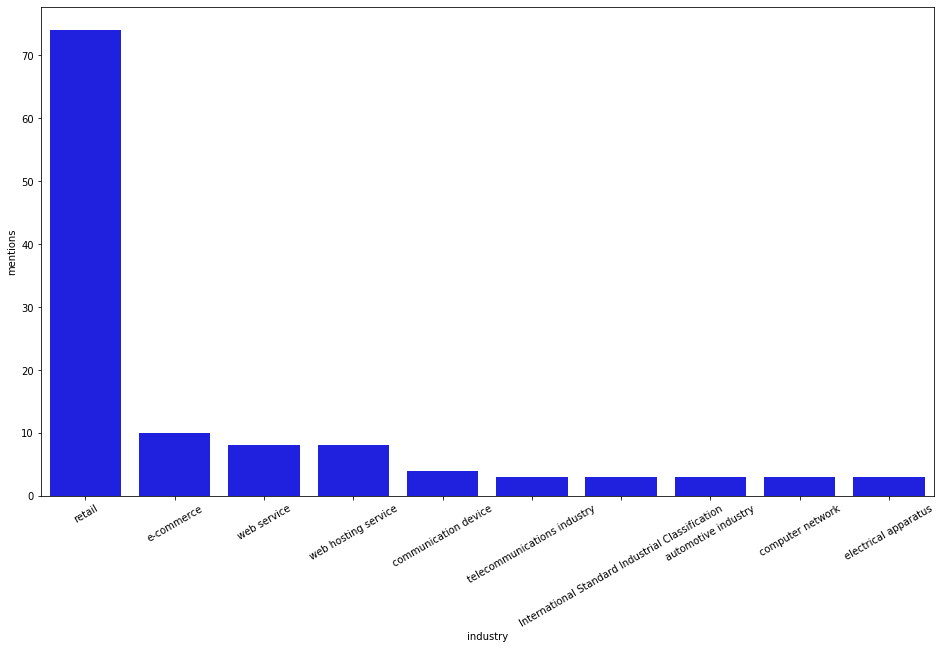

In [17]:
data = run_query("""
MATCH (t:Tag)<-[:HAS_TAG]-()-[:HAS_SECTION]->()-[:HAS_ENTITY]->(entity:Business)-[:PART_OF_INDUSTRY]->(industry)
WHERE t.name = "Stock Market"
RETURN industry.name as industry, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="industry", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


[Text(0, 0, 'GameStop'),
 Text(0, 0, 'Amazon (company)'),
 Text(0, 0, 'Elon Musk'),
 Text(0, 0, 'Alexandria Ocasio-Cortez'),
 Text(0, 0, 'Jim Cramer'),
 Text(0, 0, 'Rashida Tlaib'),
 Text(0, 0, 'Tesla, Inc.'),
 Text(0, 0, 'Ted Cruz'),
 Text(0, 0, 'Nokia'),
 Text(0, 0, 'Etsy')]

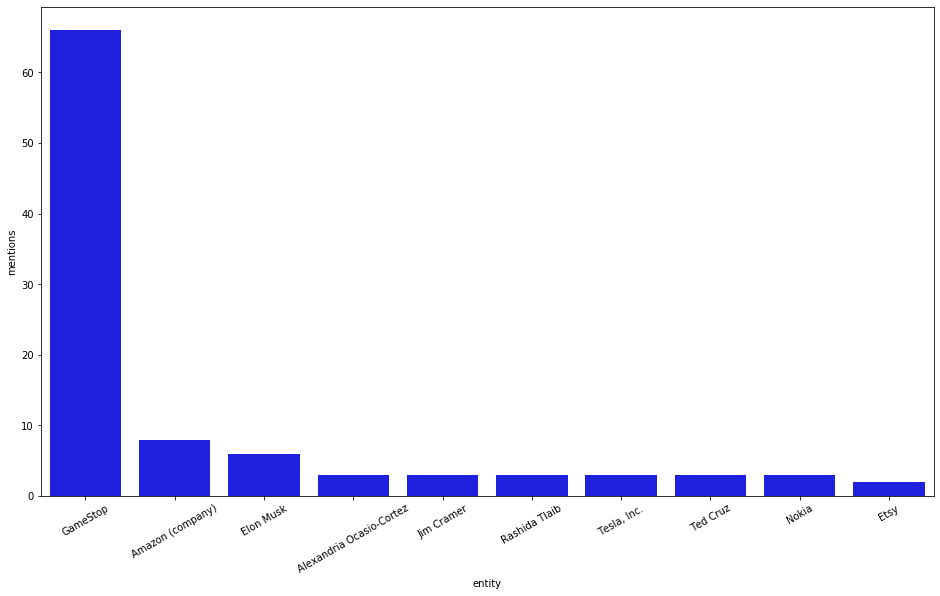

In [18]:
data = run_query("""
MATCH (t:Tag)<-[:HAS_TAG]-()-[:HAS_SECTION]->()-[:HAS_ENTITY]->(entity)
WHERE t.name = "Stock Market" AND (entity:Person OR entity:Business)
RETURN entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

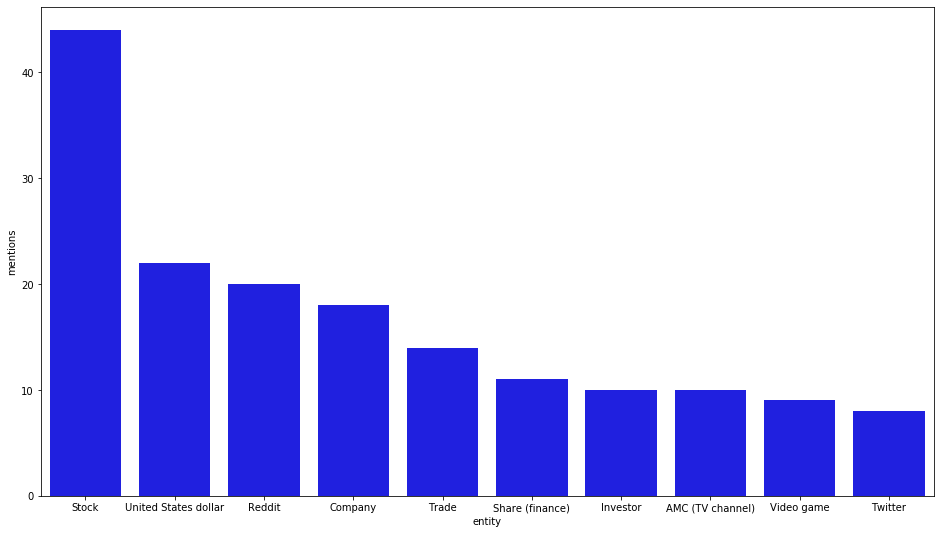

In [19]:
data = run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(other_entity)
RETURN other_entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")



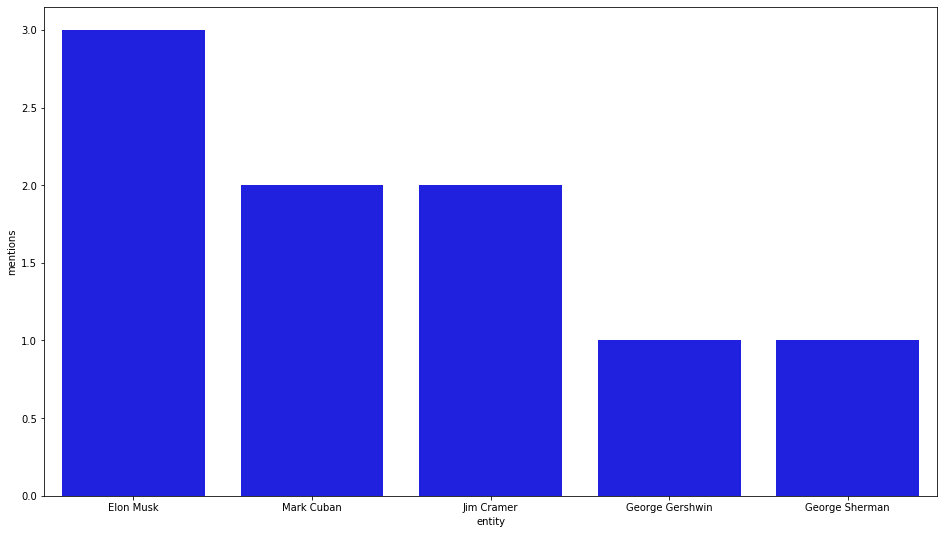

In [20]:
data = run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(other_entity:Person)
RETURN other_entity.title as entity, count(*) as mentions
ORDER BY mentions DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="entity", y="mentions", data=data, color="blue")

In [23]:
d = run_query("""
MATCH (b:Business{title:"GameStop"})<-[:HAS_ENTITY]-(section)-[:HAS_ENTITY]->(p:Person{title:"Elon Musk"})
RETURN section.text as text
""")

In [28]:
d['text'][1]

"The current low point for GameStop's stock is just the latest among twists and tales that have come to make up a crazy story. And aside from Cuban, other celebrities have gotten involved, including by Tesla CEO Elon Musk and CNBC financial commentator and former hedge fund manager Jim Cramer. There's even Michael Burry, one of the subjects of the book and movie The Big Short, who happens to be a prominent investor in GameStop."

In [29]:
run_query("""
MATCH (s:Person)<-[:HAS_ENTITY]-()-[:HAS_ENTITY]->(t:Person)
WHERE id(s) < id(t)
WITH s,t, count(*) as weight
MERGE (s)-[c:CO_OCCURENCE]-(t)
SET c.weight = weight
""")

""


In [31]:
d = run_query("""
CALL gds.wcc.write({
    nodeProjection:'Person',
    relationshipProjection:'CO_OCCURENCE',
    writeProperty:'wcc'})
YIELD componentCount, componentDistribution
""")

In [35]:
d.columns

Index(['componentCount', 'componentDistribution'], dtype='object')